In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import torch
import os.path
sys.path.append('../')
import topovelo as tpv
import matplotlib.pyplot as plt
from scipy.io import mmread, mmwrite
from numpy import savetxt
%load_ext autoreload
%autoreload 2

# Test for hard bugs

In [3]:
dataset = 'Pancreas'
root = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')

In [4]:

model_path_base = f'{root}/checkpoints/{dataset}'
figure_path_base = f'{root}/figures/{dataset}'
data_path = f'{root}/data/velovae/continuous/{dataset}'
gene_plot = tpv.sample_genes(adata, 4, 'means')

In [9]:
figure_path = f'{figure_path_base}/Graph'
model_path = f'{model_path_base}/Graph'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              attention=False)

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 901 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.49, 0.34843595768045504), (0.51, 0.7329538970887918)
(0.55, 0.31774595674199757), (0.45, 0.7678039422838004)
(0.57, 0.812504473951968), (0.43, 0.44401169136605384)
KS-test result: [0. 0. 0.]
Initial induction: 1163, repression: 837/2000


In [6]:
graph = adata.obsp['connectivities']

In [ ]:
config = {
    'n_epochs': 1,
    'n_epochs_post': 1
}
vae.train(adata, graph, config=config, plot=True, gene_plot=gene_plot, figure_path=figure_path)
#vae.save_model(model_path, 'encoder', 'decoder')
#vae.save_anndata(adata, 'velovae', data_path, file_name=f'{dataset}.h5ad')

In [25]:
vae.graph_data.data.edge_index

tensor([[   0,    0,    0,  ..., 3695, 3695, 3695],
        [  33,  246,  483,  ..., 3509, 3528, 3593]])

In [29]:
param_size = 0
for param in vae.encoder.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in vae.encoder.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 7.654MB


In [30]:
param_size = 0
for param in vae.decoder.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in vae.decoder.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 8.720MB


In [33]:
vae.save_anndata(adata, 'velovae', data_path, file_name=None)

In [39]:
cluster_edges = [('Ngn3 low EP', 'Ngn3 high EP'),
                 ('Ngn3 high EP', 'Pre-endocrine'),
                 ('Pre-endocrine', 'Delta'),
                 ('Pre-endocrine', 'Beta'),
                 ('Pre-endocrine', 'Epsilon'),
                 ('Pre-endocrine', 'Alpha')]
res, res_type = tpv.post_analysis(adata,
                                 dataset,
                                 ['VeloVAE'],
                                 ['velovae'],
                                 compute_metrics=True,
                                 genes=gene_plot,
                                 grid_size=(1,4),
                                 figure_path=figure_path,
                                 cluster_edges=cluster_edges)

Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'velovae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velovae_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 3696 cells, 2000 genes
---   Plotting  Results   ---
saving figure to file /scratch/blaauw_root/blaauw1/gyichen/figures/Pancreas/Graph/Pancreas_velovae_stream.png


# Memory Consumption

In [2]:
root = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/slide-seq/adult_cortex'
dataset = 'slide-seq-adult-cortex'
data_path_base = f'/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/{dataset}'
figure_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}'
model_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/checkpoints/{dataset}'

In [3]:
adata = anndata.read_h5ad(f'{root}/{dataset}_pp_hg.h5ad')

In [4]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 25, 50),
              device='cuda:0',
              attention=False)
graph = mmread(f'{root}/DT_nn_graph.mtx').tocsr().T
config = {
    'early_stop_thred': 1.0
}
vae.train(adata, graph, config=config, plot=False, figure_path=figure_path, embed='pos')

Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 49 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.26436819265956807), (0.55, 0.6699464796599823)
(0.65, 0.7300036933460016), (0.35, 0.23797667413812668)
KS-test result: [0. 2. 0.]
Initial induction: 95, repression: 105/200
Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a VeloVAE ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 

torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])


torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])


torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])


torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])


torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])


torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([103, 2, 200]) torch.Size([103, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])
torch.Size([128, 2, 200]) torch.Size([128, 1, 1])


  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.043
Average Set Size: 50
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]

torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Siz

torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Siz

torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Siz

torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
*********       Round 7: Early Stop Triggered at epoch 139.       *********
Change in noise variance: 0.0000
Change in x0: 0.2339
*********             Velocity Refinement Round 8              *********
torch.Size([128, 200]) torch.Size([128, 1])
torch

torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Siz

torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([103, 200]) torch.Size([103, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Size([128, 1])
torch.Size([128, 200]) torch.Siz

In [5]:
vae.save_anndata(adata, 'tpv', data_path_base, file_name=None)

computing velocity graph (using 1/32 cores)


  0%|          | 0/2525 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_pos', embedded velocity vectors (adata.obsm)


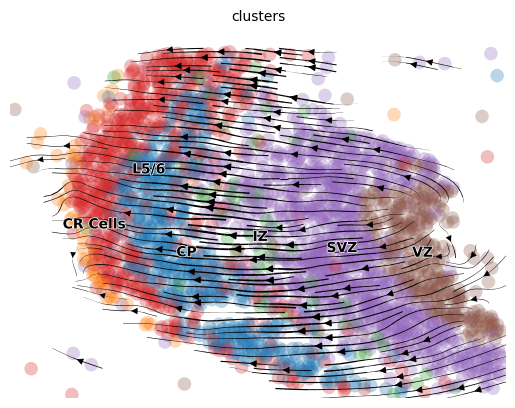

In [6]:
scv.tl.velocity_graph(adata, vkey='tpv_velocity')
scv.pl.velocity_embedding_stream(adata, vkey='tpv_velocity', basis='pos')

In [5]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'

torch.manual_seed(2022)
np.random.seed(2022)

vae2 = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 25, 50),
              device='cuda:0',
              attention=False)
config = {
    'n_epochs': 1,
    'n_epochs_post': 0
}
vae2.train(adata, graph, config=config, plot=False, figure_path=figure_path, embed='pos')

Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 49 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.26436819265956807), (0.55, 0.6699464796599823)
(0.65, 0.7300036933460016), (0.35, 0.23797667413812668)
KS-test result: [0. 2. 0.]
Initial induction: 95, repression: 105/200
Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a VeloVAE ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Checkpoint 1
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|--------------------------------------------------

Checkpoint 2.1
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   39000 KB |  178589 KB |   22908 MB |   22870 MB |
|       from large pool |   36263 KB |  172802 KB |   21983 MB |   21948 MB |
|       from small pool |    2737 KB |    9447 KB |     925 MB |     922 MB |
|---------------------------------------------------------------------------|
| Active memory         |   39000 KB |  178589 KB |   22908 MB |   22870 MB |
|       from large pool |   36263 KB |  172802 KB

Checkpoint 2.1
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   39000 KB |  178589 KB |   23779 MB |   23741 MB |
|       from large pool |   36263 KB |  172802 KB |   22822 MB |   22786 MB |
|       from small pool |    2737 KB |    9447 KB |     957 MB |     955 MB |
|---------------------------------------------------------------------------|
| Active memory         |   39000 KB |  178589 KB |   23779 MB |   23741 MB |
|       from large pool |   36263 KB |  172802 KB

  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.044
Average Set Size: 50
Change in noise variance: 0.1785
*********             Velocity Refinement Round 2              *********
Change in noise variance: 0.0007
Change in x0: 0.7452
*********             Velocity Refinement Round 3              *********
Change in noise variance: 0.0000
Change in x0: 0.5677
*********             Velocity Refinement Round 4              *********
Change in noise variance: 0.0000
Change in x0: 0.4742
*********             Velocity Refinement Round 5              *********
Change in noise variance: 0.0000
Change in x0: 0.4008
*********             Velocity Refinement Round 6              *********
Change in noise variance: 0.0000
Change in x0: 0.3833
*********             Velocity Refinement Round 7              *********
Change in noise variance: 0.0000
Change in x0: 0.3560
*********             Velocity Refinement Round 8              *********
Change in noise variance: 0.0000
Change in x0: 0.3211
*********             V

TypeError: 'NoneType' object is not subscriptable

In [9]:
vae2.graph_data.data.edge_index

tensor([[   0,    0,    0,  ..., 2524, 2524, 2524],
        [   0,   32,   52,  ..., 1478, 1515, 2524]], device='cuda:0')

In [10]:
from torch_sparse import SparseTensor
edge_index=vae2.graph_data.data.edge_index
edge_attr=vae2.graph_data.edge_weight
adj = SparseTensor(row=edge_index[0], col=edge_index[1], value=edge_attr)

In [22]:
vae2.graph_data.data.x.nelement()*vae2.graph_data.data.x.element_size() / (1024**2)

3.85284423828125

In [23]:
edge_index.nelement()*edge_index.element_size() / (1024**2)

0.267669677734375

In [24]:
edge_attr.nelement()*edge_attr.element_size() / (1024**2)

0.06691741943359375